Print the version number

In [1]:
import goats
print(goats.__version__)

0.0.32


The first thing we'll do is import the packages we need.

* `pathlib` is the built-in package for working with system paths  
* `matplotlib` is a popular third-party package for creating figures  
* `eprem` is the GOATS subpackage for working with EPREM output  

In [2]:
import pathlib

import matplotlib.pyplot as plt

from goats import eprem

Next, we'll create a stream observer, which is the type of observer that corresponds to an EPREM output file with a name like `obs######.nc`. This invokation assumes that the data file, as well as an EPREM runtime parameter file called `eprem_input_file`, are in a local subdirectory called `data`.

In [3]:
stream = eprem.Stream(350, source='data')

We can request the value of simulation runtime parameters by aliased keyword. For example, let's check the assumed mean free path at 1 au.

In [4]:
print(stream['lambda0'])

'lam0 | lambda0 | lamo': [1.] [au]


The text tells us that this simulation run used a value of 1.0 au (astronomical unit) for this parameter. It also suggests that we could have requested this value by the keywords 'lamo' or 'lam0'.

In [5]:
print(stream['lamo'])
print(stream['lam0'])

'lam0 | lambda0 | lamo': [1.] [au]
'lam0 | lambda0 | lamo': [1.] [au]


We can also request observable quantities by aliased keyword. Here is the radial velocity.

In [6]:
vr = stream['Vr']
print(vr)

'vr | Vr', unit='m s^-1', axes=['time', 'shell']


The text tells us that the radial velocity output array has a time axis and a shell axis. EPREM shells are logical surface of nodes in the Lagrangian grid. Each shell index along a given stream represents one node. We can observe radial velocity at a single time (e.g., 1 hour of real time since simulation start) on a single node as follows:

In [7]:
t0 = 1.0, 'hour'
vr.observe(time=t0, shell=1000)

core.observed.Quantity('vr | Vr': unit='m s^-1', dimensions=['time', 'shell'], parameters=[])

In the case of a constant isotropic solar wind, the stream nodes would extend radially outward from the Sun; with some trial-and-error, we could figure out which shell is closest to a particular radius (e.g., 1 au).

Instead, we often want to interpolate an observation to the radius of interest.

In [8]:
observed = vr.observe(radius=[0.1, 'au'])

Now that we have an observation of the radial velocity at 0.1 au as a function of time, we can plot it. First, we'll define intermediate variables to hold the time in hours and the radial velocity in kilometers per second.

In [9]:
time = observed['time']['hour']
data = observed.data['km / s']

Next, we'll make sure there's a `figures` directory (to avoid cluttering the current directory) and load the plotting library.

In [10]:
figpath = pathlib.Path('figures').resolve()
figpath.mkdir(exist_ok=True)

Finally, we'll create and save the plot.

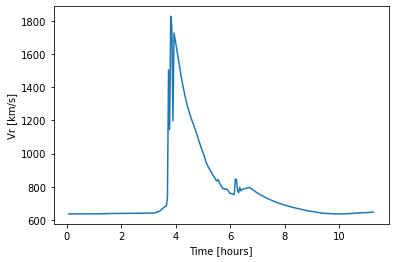

In [11]:
plt.plot(time, data)
plt.xlabel('Time [hours]')
plt.ylabel('Vr [km/s]')
plt.savefig(figpath / 'vr-hours.png')

There are many other observable quantities available to an observer, and they are not limited to those in the observer's source data.

In [12]:
print('flux' in stream.observables)
print('mean free path' in stream.observables)

True
True


In [13]:
stream['flux']

core.observable.Quantity('Flux | j(E) | j | J(E) | J | flux', unit='J^-1 s^-1 sr^-1 m^-2', axes=['time', 'shell', 'species', 'energy'])

In [14]:
stream['mean free path']

core.observable.Quantity('mean_free_path | mfp | mean free path', unit='m', axes=['time', 'shell', 'species', 'energy'])

We can even create observable quantities by symbolically composing existing observable quantities

In [15]:
stream['mfp / Vr']

core.observable.Quantity('mfp / Vr', unit='s', axes=['time', 'shell', 'species', 'energy'])

In [16]:
stream['rho * energy']

core.observable.Quantity('rho * energy', unit='kg m^-1 s^-2', axes=['species', 'energy', 'time', 'shell'])

Note that the unit is consistent with the composed quantity and that the axes of the composed quantity represent the union of the axes of the component quantities.

To illustrate full use of a composed quantity, consider observing the ratio of the mean free path of protons with 1 and 5 MeV to the radial velocity of the solar wind.

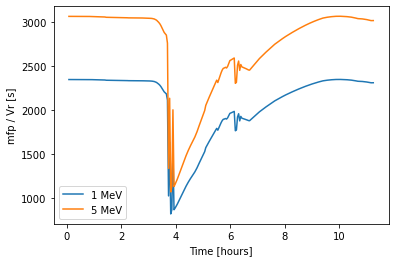

In [17]:
observed = stream['mfp / Vr'].observe(radius=[0.1, 'au'], energy=[1, 5, 'MeV'])
lines = plt.plot(observed['time']['hour'], observed.array)
lines[0].set_label('1 MeV')
lines[1].set_label('5 MeV')
plt.xlabel('Time [hours]')
plt.ylabel('mfp / Vr [s]')
plt.legend()
plt.savefig(figpath / 'mfp_vr-hours.png')